In [2]:
import h5py
import numpy as np
import math
import glob
import os
import umap
import hdbscan
import seaborn as sns
import pandas as pd
import pickle
import openpyxl
import cv2
from scipy import ndimage as ndi

from functools import reduce
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import sklearn.cluster as cluster
from moviepy.editor import *
import imageio


# General Functions

In [22]:
def get_running_total(lst: list) -> list:
    """
    Compute the running total for a list of numbers.
    
    Given a list of numbers, this function returns a new list 
    where each element is the cumulative sum of the elements 
    up to that point in the original list.

    Parameters:
    - lst (list): A list of numbers.

    Returns:
    - list: A list containing the running total.

    Example:
    >>> get_running_total([1, 2, 3, 4])
    [1, 3, 6, 10]
    """

    def accumulator(acc, x):
        if acc:
            return acc + [acc[-1] + x]
        else:
            return [x]
        
    return reduce(accumulator, lst, [])

def make_dict(my_list):
    my_dict = {}
    for i in range(len(my_list)):
        my_dict[my_list[i]] = i
    return my_dict

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    node_vel = np.linalg.norm(node_loc_vel,axis=1)
    return node_vel

class sleap_vid():

    def __init__(self, filename, track_no):
        self.name = filename
        self.features = {}
        self.mice = track_no
        self.get_info(filename)

    def get_info(self, filename):
        with h5py.File(filename, "r") as f:
            tracks= [n.decode() for n in f["track_names"][:]]
            locations = f["tracks"][:].T
            locations = locations[:,:,:,:self.mice]
            self.locations = fill_missing(locations)
            nodes = [n.decode() for n in f["node_names"][:]]
            self.tracks = tracks
            self.nodes = nodes
            self.track_dict = make_dict(tracks)
            self.node_dict = make_dict(nodes)

    def node_velocity(self, node, win=25, poly=3, normalization_factor=None):
        """
        takes in node and returns the velocity of that node 
        for each mouse

        Args: 
            node: string, name of node
        
        Returns:
            velocities: 2d np.array of floats (d = 2 x #of frames)
                where each element is the velocity for that node
                distances[0] = velocities for mouse2
                distances[1] = velocities for mouse2
        """
        node_loc1 = self.locations[:, self.node_dict[node], :, 0]
        node_loc2 = self.locations[:, self.node_dict[node], :, 1]
        if normalization_factor != None:
            node_loc1 = node_loc1 * normalization_factor
            node_loc2 = node_loc2 * normalization_factor
        m1_vel = smooth_diff(node_loc1, win, poly)
        m2_vel = smooth_diff(node_loc2, win, poly)
        velocities = np.array([m1_vel,m2_vel])
        return velocities 
   
    def distances_between_mice(self, node, normalization_factor=None):
        """
        takes in node name
        returns a list of distances between the nodes of the two mice

        Args:
            node: string, name of node
        Returns:
            c_list: 1D np.array of floats (d = # of frames)
        """
        locations = self.locations 
        node_index = self.node_dict[node]
        x1 = locations[:,node_index,0,0]
        y1 = locations[:,node_index,1,0]
        # x , y coordinate of nose for mouse 1
        x2 = locations[:,node_index,0,1]
        y2 =  locations[:,node_index,1,1]
        # x and y coordinate of nose of mouse 2
        # solve for c using pythagroean theory
        distances = np.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
        if normalization_factor != None: 
            distances = distances * normalization_factor
            distances = distances.T.flatten()
        return distances
    
    def distances_between_nodes(self, node1, node2, normalization_factor = None):
        """
        takes in two nodes and returns the distances between those nodes 
        for each mouse

        Args: 
            node1: string, name of node 1
            node2: string, name of node 2 
        
        Returns:
            distances: 2d np.array of floats (d = 2 x #of frames)
                where each element is the distance between node1 and node2 
                distances[0] = distances for mouse1
                distances[1] = distances for mouse2
        """
        locations = self.locations
        node_index1 = self.node_dict[node1]
        node_index2 = self.node_dict[node2]
        x1,y1 = locations[:, node_index1,0,0], locations[:,node_index1,1,0]
        # x , y coordinate of node 1 for mouse 1
        x2,y2 = locations[:,node_index2,0,0], locations[:,node_index2,1,0]
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[:,node_index1,0,1], locations[:,node_index1,1,1]
        # x and y coordinate of node 1 of mouse 2
        x4, y4 = locations[:,node_index2,0,1], locations[:,node_index2,1,1]
        # solve for c using pythagroean theory
        c2 = np.sqrt(((x3 -x4)**2)+ ((y3 - y4)**2))
        c1 = np.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
        if normalization_factor != None:
            c2 = (c2*normalization_factor).T.flatten()
            c1 = (c1*normalization_factor).T.flatten()
        distances = np.array[c1, c2]
        return distances
    
    def distances_to_point(self, node, point, normalization_factor = None):
        # CONFIRMED THAT IT WORKS in terms of doing the math by hand
        """
        takes in two nodes and returns the distances between those nodes 
        for each mouse

        Args: 
            node1: string, name of node 1
            point: tuple or list of two floats,
                x and y coordinate of desired point

        Returns:
            distances: 2d np.array of floats (d = 2 x #of frames)
                where each element is the distance between node and point 
                distances[0] = distances for mouse1
                distances[1] = distances for mouse2
        """
        locations = self.locations
        node_index = self.node_dict[node]
        px, py = point[0], point[1]
        x1,y1 = locations[:, node_index,0,0], locations[:,node_index,1,0]
        # x , y coordinate of node 1 for mouse 1
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[:,node_index,0,1], locations[:,node_index,1,1]
        # x and y coordinate of node 1 of mouse 2
        px = np.full_like(x1, fill_value=px)
        py = np.full_like(y1, fill_value=py)
        # solve for c using pythagroean theory
        c2 = np.sqrt(((x3 -px)**2)+ ((y3 - py)**2))
        c1 = np.sqrt(((x1 - px)**2) + ((y1 - py)**2))
        if normalization_factor != None:
            c2 = (c2*normalization_factor).T.flatten()
            c1 = (c1*normalization_factor).T.flatten()
        distances = np.array([c1, c2])
        return distances


    def node_angles(self, node1, node2, node3):
        """
        takes in locations and three nodes, calculates angle between the three points 
        with the second node being the center point
        
        Args:  
            node1: string, name of node 1
            node2: string, name of node 2 
            node3: string, name of node 3

        Returns:
            ang: 2d np. array (d = 2 x # of frames)
                where each element is the angle between 
                node1 and node3 with node2 as center point 
                anles_all_mice[0] = angles for mouse1
                anles_all_mice[1] = angles for mouse2
        """
        locations = self.locations  
        node_index_1 = self.node_dict[node1]
        node_index_2 = self.node_dict[node2]
        node_index_3 = self.node_dict[node3]
        ax = locations[:,node_index_1, 0, :]
        ay = locations[:,node_index_1, 1, :]
        bx = locations[:,node_index_2, 0, :]
        by = locations[:,node_index_2, 1, :]
        cx = locations[:,node_index_3,0,:]
        cy = locations[:,node_index_3, 1, :]
        ang = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_swapped = np.arctan2(cy-by, cx-bx) - np.arctan2(cy-by, cx-bx) 
        ang = np.maximum(ang, ang_swapped)
        return ang.T
    
    def point_angles(self, node1, node2, point):
        """
        takes in locations and three nodes, calculates angle between the three points 
        with the second node being the center point
        
        Args:  
            node1: string, name of node 1
            node2: string, name of node 2 
            point: tuple or list of two floats,
                x and y coordinate of desired point

        Returns:
            ang: 2d np. array (d = 2 x # of frames)
                where each element is the angle between 
                node1 and point with node2 as center point 
                anles_all_mice[0] = angles for mouse1
                anles_all_mice[1] = angles for mouse2
        """
        locations = self.locations  
        node_index_1 = self.node_dict[node1]
        node_index_2 = self.node_dict[node2]
        px, py = point[0], point[1]
        ax = locations[:,node_index_1, 0, :]
        ay = locations[:,node_index_1, 1, :]
        bx = locations[:,node_index_2, 0, :]
        by = locations[:,node_index_2, 1, :]
        px = np.full_like(ax, fill_value=px)
        py = np.full_like(ay, fill_value=py)
        ang = np.arctan2(py-by, px-bx) - np.arctan2(ay-by, ax-bx) 
        ang_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(py-by, px-bx) 
        ang = np.maximum(ang, ang_swapped)
        return ang.T

    def orientation(self):
        """
        Takes in locations and nose and thorax node index to calculate the angle of orientation
        between mice where two mice facing each other results in pi
        theta = 0 means they are not facing each other 
        
        """
        locations = self.locations
        nose_node = self.node_dict['nose']
        thorax_node = self.node_dict['thorax']
        forehead = self.node_dict['forehead']
        ax = locations[:, nose_node, 0, 0]
        ay = locations[:, nose_node, 1, 0]
        bx = locations[:,thorax_node, 0, 0]
        by = locations[:,thorax_node, 1, 0]
        cx = locations[:, forehead, 0, 1]
        cy = locations[:,forehead, 1, 1]
        ang_m1 = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_m1_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(cy-by, cx-bx)
        ax = locations[:, nose_node, 0, 1]
        ay = locations[:, nose_node, 1, 1]
        bx = locations[:,thorax_node, 0, 1]
        by = locations[:,thorax_node, 1, 1]
        cx = locations[:, forehead, 0, 0]
        cy = locations[:,forehead, 1, 0]
        ang_m2 = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_m2_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(cy-by, cx-bx) 
        ang_m1 = np.maximum(ang_m1,ang_m1_swapped)
        ang_m2 = np.maximum(ang_m2,ang_m2_swapped)
        return np.array([ang_m1, ang_m2])

## Tube Test Specific Functions

In [23]:
def get_mouse_sides(locations):
    '''
    takes in locations
    returns (left mouse index, right mouse index)
    '''
    if locations[0,1,0,0] > locations[0,1,0,1]:
        #if mouse 0 has a greater starting x value for its nose, then it is the right mouse
        return (1, 0)
    else:
        return (0, 1)
    
def smooth_diff_one_dim(node_loc, win=25, poly=3):
    """
    node_loc is a [frames] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    node_loc_vel[:] = savgol_filter(node_loc[:], win, poly, deriv=1)
    return node_loc_vel

def get_velocities(locations, node_index):

    left_mouse, right_mouse = get_mouse_sides(locations)
    node_loc_left = locations[:,node_index, 0,left_mouse]
    # node loc (x,y) of node of mouse 1
    node_loc_right = (locations[:,node_index, 0,right_mouse]) * (-1)
    # x,y's of node of mouse 2 
    
    m1_vel = smooth_diff_one_dim(node_loc_left)
    m2_vel = smooth_diff_one_dim(node_loc_right)
    velocities = [m1_vel,m2_vel]
    return velocities 

def get_distances_between_mice(self, node):
        #confirmed does what i want it to
        """
        takes in locations and node index 
        returns a list of distances between the nodes of the two mice
        """
        c_list = []
        locations = self.locations 
        node_index = node_dict[node]
        left_mouse, right_mouse = get_mouse_sides(locations)
        for i in range(len(locations)):
        
            (x1,y1) = (locations[i,node_index,0,left_mouse], locations[i,node_index,1,left_mouse])
            # x , y coordinate of nose for mouse 1
            (x2, y2) = (locations[i,node_index,0,right_mouse], locations[i,node_index,1,right_mouse])
            # x and y coordinate of nose of mouse 2
            # solve for c using pythagroean theory
            a2 = (x1 - x2) ** 2 
            b2 = (y1 - y2) ** 2 
            c = math.sqrt(a2 + b2)
            if x1 > x2:
                c_list.append(-1*c)
            else:
                c_list.append(c)
        return c_list

# Data Load for Reward Comp


### Box Set Up: reward point coordinate and length of box

In [24]:
path = r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\corner_labeling"
ending = "*.h5"
search_path = os.path.join(path, ending)
box_setup ={}
for filename in glob.glob(search_path):
    file = os.path.basename(filename)
    file = file[:file.index('.')]
    box = sleap_vid(filename, track_no=5)
    box_setup[file] = {}
    reward_port = box.locations[:,box.node_dict['reward_port'], :,:].flatten()
    #grab reward port coordinates
    box_setup[file]['reward_port'] = reward_port
    x_diff = box.locations[:,box.node_dict['box_bottom_left'], 0,:] - box.locations[:,box.node_dict['box_bottom_right'], 0,:]
    y_diff = box.locations[:,box.node_dict['box_bottom_left'], 1,:] - box.locations[:,box.node_dict['box_bottom_right'], 1,:]
    box_width = np.sqrt(x_diff**2+y_diff**2)
    box_setup[file]['bottom_left'] = box.locations[:,box.node_dict['box_bottom_left'], :,:].flatten()
    box_setup[file]['bottom_right'] = box.locations[:,box.node_dict['box_bottom_right'],:,:].flatten()
    #create a normalization factor for distances across recordings
    distance_normalization_factor = 300/box_width
    box_setup[file]['distance_normalization_factor'] = distance_normalization_factor


### Tone data

In [25]:
tone_times_df = pd.read_excel(r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\reward_comp_tone_sleap_frames.xlsx")

ALL_ITIS = [80, 90, 80, 75, 100, 95, 90, 80,
             90, 100, 90, 120, 90, 85, 90, 95, 
             120, 80, 95, 80, 90, 80, 75, 100, 95,
               90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 
               80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90,
                 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]
FRAME_RATE = 30
ALL_ITIS = [num * FRAME_RATE for num in ALL_ITIS]
ALL_TRIAL_NUMBERS = 19
tone_times_df = tone_times_df[tone_times_df["Frame Start"].astype(str).str.isnumeric()]
tone_times_df["all_tone_frame"] = tone_times_df.apply(lambda row: get_running_total([row["Frame Start"]] + ALL_ITIS), axis=1)

### Sleap tracking

In [26]:
path = r"C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\pilot_3\reward_competition\sleap_pose_tracking"
ending = "*.h5"
search_path = os.path.join(path, ending)
info ={}
total_frames = 0
for filename in glob.glob(search_path):
    file = os.path.basename(filename)
    file = file[:file.index('.')]
    info[file] = sleap_vid(filename, track_no=2)
    total_frames = info[file].locations.shape[0] + total_frames
    result_series = tone_times_df.loc[tone_times_df['File Name'] == file,'Strain']
    tones = tone_times_df.loc[tone_times_df['File Name'] == file,'all_tone_frame']
    tones = tones[0:ALL_TRIAL_NUMBERS]
    info[file].strain = result_series.iloc[0] if not result_series.empty else None
    info[file].tones = tones.iloc[0] if not tones.empty else None

## Feature Extraction

### Feature List


1. distance between thoraxes
2. velocity of mouse 1 + velocity of mouse 2 
3. | velocity of mouse 1 - velocity of mouse 2 |
4. sum of the angles of orientation between mouse 1 to mouse 2 and mouse 2 to mouse 1
5. | difference of the angles of orientation between mouse 1 to mouse 2 and mouse 2 to mouse 1 | 
6. sum of angles of orientation of mice to port 
7. | difference of angles of orientation of mice to port | 
8. sum of distances to port of mice
9. | differences of distances to port of mice |

### Feature calculations

In [7]:
is_first = True
recording_labels = []
frame_indice_labels = []
strain_labels = []
#trial length = 30 fps * 10 second tone
trial_length = 10*30
for file, recording in info.items():
    #creating arrays for recording name, strain, frame indice, and trial indice (0 for iti, 0-10 for tone)
    recording_labels += [file] * recording.locations.shape[0]
    strain_labels += [recording.strain] * recording.locations.shape[0]
    frame_indice_labels = np.concatenate([frame_indice_labels,np.arange(0, recording.locations.shape[0])], axis = 0)
    temp_trial_indices = np.zeros(recording.locations.shape[0])
    #loading in normalization_factor since not all the videos are the same size / resolution
    distance_normalization_factor = box_setup[file]['distance_normalization_factor']
    #loading in reward_point (x,y)
    reward_port = box_setup[file]['reward_port']
    #creating the tone snippets from 0-10 for the frames during the tone
    for trial in recording.tones:
        try:
            temp_trial_indices[trial:trial+trial_length] = np.linspace(0,10,300)
        except ValueError:
            pass
    if is_first:
        trial_indices = temp_trial_indices
    else: 
        trial_indices = np.concatenate([trial_indices, temp_trial_indices])
    # features 1 - 2 distance between thoraxes and noses
    f1 = recording.distances_between_mice('thorax', distance_normalization_factor) # distances between mice works 
    #features 3-4: velocities of each mouse
    velocities = recording.node_velocity('thorax', normalization_factor = distance_normalization_factor)
    f2 = velocities[0] + velocities[1]# this one is from sleap so assuming this works
    f3 = np.abs(velocities[0] - velocities[1])
    #feature 5: angle of orientation between mice, 2pi is facing each other
    # 0 radians is not facing each other (or parallel)
    orientations = recording.orientation()
    f4 = orientations[0] + orientations [1]# this works
    f5 = np.abs(orientations[0] - orientations [1])
    #feature 6-7: angle from nose to forehead to reward port
    angle_to_port = recording.point_angles('nose', 'thorax', reward_port)
    distance_to_port = recording.distances_to_point('nose', reward_port, distance_normalization_factor)
    f6 = angle_to_port[0] + angle_to_port[1]# this works with thorax
    f7 = np.abs(angle_to_port[0] - angle_to_port[1])
    #feature 8-9: distance to reward point for each mosue
    f8 = distance_to_port[0] + distance_to_port[1] # this works
    f9 = np.abs(distance_to_port[0] - distance_to_port[1])
    if is_first:
        features = np.stack([f1, f2, f3, f4, f5, f6, f7, f8, f9])
    else:
        temp_features =  np.stack([f1, f2, f3, f4, f5, f6, f7, f8, f9])
        features = np.concatenate([features,temp_features], axis = 1)
    is_first = False
recording_labels = np.array(recording_labels)
strain_labels = np.array(strain_labels)
zscored_features = []
for i in range(features.shape[0]):
    mean = np.mean(features[i])
    std_dev = np.std(features[i])
    normalized = (features[i]-mean)/std_dev
    zscored_features.append(normalized)
features = np.concatenate([features, np.stack(zscored_features)], axis = 0)
feature_names = ['thorax distances', 'mouse velocity sum',
                'mouse velocity diff', 'orientation b/w mice sum',
                'orientation b/w mice diff', 'orientation to port sum',
                'orientation to port diff', 'distance to port sum',
                'distance to port diff']
for name in range(len(feature_names)):
    zscore_name = feature_names[name]+'_zscore'
    feature_names.append(zscore_name)
new_columns = ['Strain', 'Recording', 'frame indice', 'trial_indice']
column_names = feature_names + new_columns
data = np.column_stack([features.T, 
                        strain_labels[:, None],
                        recording_labels[:, None],
                        frame_indice_labels[:, None],
                        trial_indices[:,None]])
df = pd.DataFrame(data, columns = column_names)
reduced_frames = len(df) 
every_third_index = np.arange(0, reduced_frames, 3)
subsample_df = df.iloc[every_third_index]

# Feature Visualization


Video read successful!


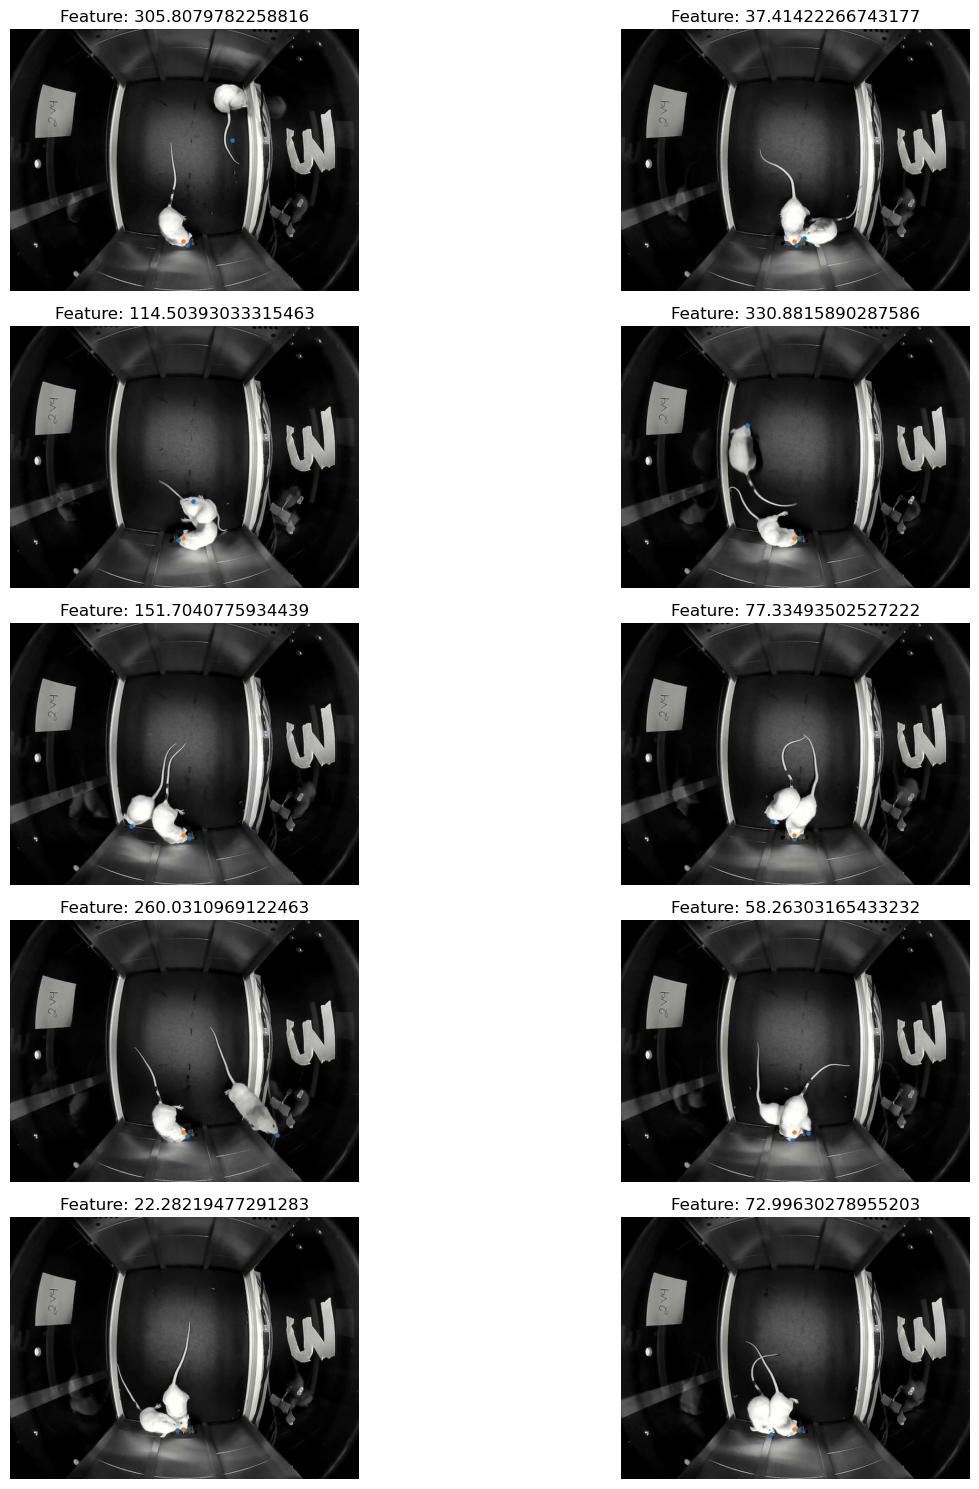

In [8]:

#Load your video using cv2.VideoCapture()
#pick random video file
cap = cv2.VideoCapture(r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\videos\10-03-22_Test_23_5-2v5-4.fixed.mp4')  # Replace 'your_video.mp4' with your video file
#insert video file base name 
file = '10-03-22_Test_23_5-2v5-4'
sleap = info[file]

#and pick feature 
feature = 'distance to port sum'
if not cap.isOpened(): 
    print("Could not open the video file!")
else:
    print("Video read successful!")
    success, image = cap.read()
    recording_df = df[df['Recording'] == file]
    my_array = np.array(recording_df[feature]) # Example array for demonstration
    frame_list = np.arange(1, sleap.locations.shape[0]+1)
    random_frames = np.random.choice(frame_list, size=10, replace=False)
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    for idx, frame_num in enumerate(random_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)  # Frame indexing starts from 0
        success, image = cap.read()
        if success:
            # Convert BGR image to RGB for display with matplotlib
            frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Plot on the respective subplot
            row = idx // 2  # Calculate subplot row
            col = idx % 2  # Calculate subplot column
            axs[row, col].imshow(frame_rgb)
            axs[row, col].scatter(
                #pick nodes that you want to visualize, last dimenison is mouse
                #0 = mouse 1 , 1 = mouse 2 
                sleap.locations[frame_num, sleap.node_dict['nose'], 0, :],
                sleap.locations[frame_num, sleap.node_dict['nose'], 1, :],
                s=5
            )
            axs[row, col].scatter(box_setup[file]['reward_port'][0],
                                  box_setup[file]['reward_port'][1],s=5)
            # axs[row, col].scatter(box_setup[file]['bottom_left'][0],
            #                       box_setup[file]['bottom_left'][1],s=5)
            # axs[row, col].scatter(box_setup[file]['bottom_right'][0],
            #                       box_setup[file]['bottom_right'][1],s=5)
            # axs[row, col].scatter(
            #     sleap.locations[frame_num, sleap.node_dict['thorax'], 0, :],
            #     sleap.locations[frame_num, sleap.node_dict['thorax'], 1, :],
            #     s=5
            # )
            # axs[row, col].scatter(
            #     sleap.locations[frame_num, sleap.node_dict['forehead'], 0, :],
            #     sleap.locations[frame_num, sleap.node_dict['forehead'], 1, :],
            #     s=5)
            axs[row, col].axis('off')  # Turn off axis labels and ticks
            axs[row, col].set_title(f"Feature: {my_array[frame_num]}")
    plt.tight_layout()  # Adjust subplot layout
    plt.show()
cap.release()


# UMAPS

In [9]:

#Load your video using cv2.VideoCapture()
#pick random video file
cap = cv2.VideoCapture(r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\videos\10-03-22_Test_23_5-2v5-4.fixed.mp4')  # Replace 'your_video.mp4' with your video file
#insert video file base name 
file = '10-03-22_Test_23_5-2v5-4'
sleap = info[file]

#and pick feature 
feature = ''
try:
    if not cap.isOpened(): 
        print("Could not open the video file!")
    else:
        print("Video read successful!")
        success, image = cap.read()
        recording_df = df[df['Recording'] == file]
        my_array = np.array(recording_df[feature]) # Example array for demonstration
        frame_list = np.arange(1, sleap.locations.shape[0]+1)
        random_frames = np.random.choice(frame_list, size=10, replace=False)
        fig, axs = plt.subplots(5, 2, figsize=(15, 15))
        for idx, frame_num in enumerate(random_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)  # Frame indexing starts from 0
            success, image = cap.read()
            
            if success:
                # Convert BGR image to RGB for display with matplotlib
                frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Plot on the respective subplot
                row = idx // 2  # Calculate subplot row
                col = idx % 2  # Calculate subplot column
                axs[row, col].imshow(frame_rgb)
                axs[row, col].scatter(
                    #pick nodes that you want to visualize, last dimenison is mouse
                    #0 = mouse 1 , 1 = mouse 2 
                    sleap.locations[frame_num, sleap.node_dict['nose'], 0, :],
                    sleap.locations[frame_num, sleap.node_dict['nose'], 1, :],
                    s=5
                )
                axs[row, col].scatter(box_setup[file]['bottom_left'][0],
                                    box_setup[file]['bottom_left'][1],s=5)
                axs[row, col].scatter(box_setup[file]['bottom_right'][0],
                                    box_setup[file]['bottom_right'][1],s=5)
                axs[row, col].scatter(
                    sleap.locations[frame_num, sleap.node_dict['thorax'], 0, :],
                    sleap.locations[frame_num, sleap.node_dict['thorax'], 1, :],
                    s=5
                )
                axs[row, col].scatter(
                    sleap.locations[frame_num, sleap.node_dict['forehead'], 0, 1],
                    sleap.locations[frame_num, sleap.node_dict['forehead'], 1, 1],
                    s=5)
                axs[row, col].axis('off')  # Turn off axis labels and ticks
                axs[row, col].set_title(f"Feature: {my_array[frame_num]}")
        plt.tight_layout()  # Adjust subplot layout
        plt.show()
    cap.release()
except: 
    print('check feature and file name')


Video read successful!
check feature and file name


### Color dictionary for labels

In [12]:
def make_color_dict(column_name, df, cmap = 'gist_ncar'):
    unique_labels = df[column_name].unique()
    color_map = plt.cm.get_cmap(cmap, len(unique_labels))
    # Create a dictionary to map labels to colors
    label_color_dict = {label: color_map(i) for i, label in enumerate(unique_labels)}
    # Assign colors to each label based on the color map
    #colors = [label_color_dict[label] for label in recording_labels]
    #colors = np.array(colors)
    return label_color_dict

def show_palette(color_dict):
    colors = list(color_dict.values())
    palette = sns.color_palette(colors)
    sub_pallete_no = int(len(palette)//5)
    divided_palettes = [palette[i:i+5] for i in range(0, len(palette), 5)]  # Create 6 lists of 5 elements
    divided_palettes.append(palette[sub_pallete_no:])
    # Plotting color swatches for each label
    for color_palette in divided_palettes:
        sns.palplot(color_palette)  # Plotting color swatches for each sub-palette
        
        # Adding labels above the color swatches
        plt.xticks([])  # Hide x-axis ticks
        for color, label in zip(color_palette, list(color_dict.keys())):
            plt.text(color_palette.index(color), -0.5, label, ha='center', fontsize=8, rotation=45)

        plt.show()
#recording_colors = make_color_dict('Recording', subsample_df)
strain_colors = {'C57': 'r', 'CD1':'b'}

## UMAP calls

In [11]:
zscore_df = subsample_df.iloc[:,9:18]
zscore_df

,thorax distances_zscore,mouse velocity sum_zscore,mouse velocity diff_zscore,orientation b/w mice sum_zscore,orientation b/w mice diff_zscore,orientation to port sum_zscore,orientation to port diff_zscore,distance to port sum_zscore,distance to port diff_zscore
0,2.0536650087667576,-0.7800775332977785,-0.6450783832519964,0.3615252494887009,0.6197853823246732,0.8904978249590381,0.6877863042562761,2.224739484144293,2.1224397967418476
3,2.0536650087667576,-0.7800775332977892,-0.6450783832520078,0.3615252494887009,0.6197853823246732,0.8904978249590381,0.6877863042562761,2.224739484144293,2.1224397967418476
6,2.0536650087667576,-0.7800775332977962,-0.6450783832520145,0.3615252494887009,0.6197853823246732,0.8904978249590381,0.6877863042562761,2.224739484144293,2.1224397967418476
9,2.0536650087667576,-0.7800775332977973,-0.6450783832520116,0.3615252494887009,0.6197853823246732,0.8904978249590381,0.6877863042562761,2.224739484144293,2.1224397967418476
12,2.0536650087667576,-0.7800775332977995,-0.6450783832520144,0.3615252494887009,0.6197853823246732,0.8904978249590381,0.6877863042562761,2.224739484144293,2.1224397967418476
...,...,...,...,...,...,...,...,...,...
1832811,2.86214682002118,-0.635491583663596,-0.45964197579760374,-0.3529249655789837,0.8289979549590583,-0.9127280287140658,-0.964153113261697,1.93632364064921,2.2927555416676437
1832814,2.861420159416655,-0.6704958765165381,-0.5045361742211489,-0.3496359844281543,0.8350396581800417,-0.9138729027118484,-0.962584413160909,1.9370642764253132,2.291915081772637
1832817,2.8609009380008303,-0.6589772499916069,-0.48976314318324093,-0.3534478850116385,0.8374041956153937,-0.911384198362387,-0.9659944222722981,1.9371025380731022,2.291871663156467
1832820,2.8682127093578567,-0.6323968809143423,-0.45567291406368077,-0.3285829587172593,0.8842210222724357,-0.9030516551553938,-0.9774116274791123,1.93718830263299,2.291774339106882


### Enhanced Clusterable UMAP

In [12]:
clusterable_embedding = umap.UMAP(
    n_neighbors= 18,
    min_dist=0,
    n_components=2,
    random_state=42,
).fit_transform(zscore_df)

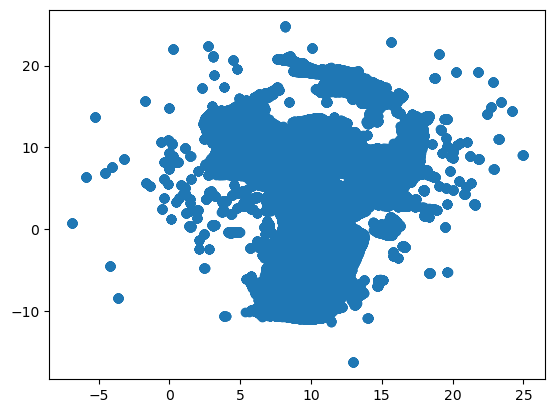

In [13]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1])

### Standard Embedding UMAP

In [14]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(zscore_df)


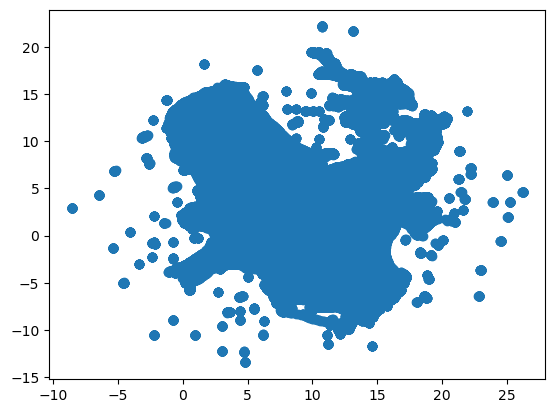

In [15]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1])

In [16]:
subsample_df['embedding_x'] = clusterable_embedding[:,0]
subsample_df['embedding_y']= clusterable_embedding[:,1]
subsample_df['embedding_x_standard'] = standard_embedding[:,0]
subsample_df['embedding_y_standard'] = standard_embedding[:,1]

### Clustering Calls

In [17]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7000, max_cluster_size=460000).fit_predict(clusterable_embedding)
kmeans_labels = cluster.KMeans(n_clusters=12).fit_predict(clusterable_embedding)


In [18]:
standard_hdbscan_labels = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=7000, max_cluster_size=450000).fit_predict(standard_embedding)
standard_kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(standard_embedding)

In [19]:
subsample_df['kmeans_label'] = standard_kmeans_labels
subsample_df['hdbscan_labels'] =  standard_hdbscan_labels
subsample_df['enhanced_kmeans_labels'] = kmeans_labels
subsample_df['enhanced_hdbscan_labels'] = hdbscan_labels
clustered= (hdbscan_labels >= 0)
clustered_df = subsample_df#[subsample_df['cluster_label']]>= 0]
clustered_dataset = len(clustered_df) 
random_subsample = np.random.choice(clustered_dataset, size=(clustered_dataset//10), replace = False)
subsample_cluster_df = clustered_df.iloc[random_subsample]
trial_df = clustered_df[clustered_df['trial_indice'].astype(float) > 0]
unclustered = subsample_df[subsample_df['hdbscan_labels']==-1]

### Pickle the results

In [3]:
# with open('clustered_df.pkl', 'wb') as file:
#     pickle.dump(clustered_df, file)
with open('clustered_df.pkl', 'rb') as file:
    clustered_df = pickle.load(file)

## Cluster plots

### Standard Embedding

In [4]:
plt.figure(figsize=(5,5))
scatter = plt.scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['kmeans_label'],
            label=subsample_cluster_df['kmeans_label'],
            s=0.1,
            cmap='Spectral')
plt.title('Behavioral Clusters')
plt.legend(*scatter.legend_elements(), bbox_to_anchor = (1,1))
plt.show()

NameError: name 'subsample_cluster_df' is not defined

<Figure size 500x500 with 0 Axes>

### Enhanced Embedding

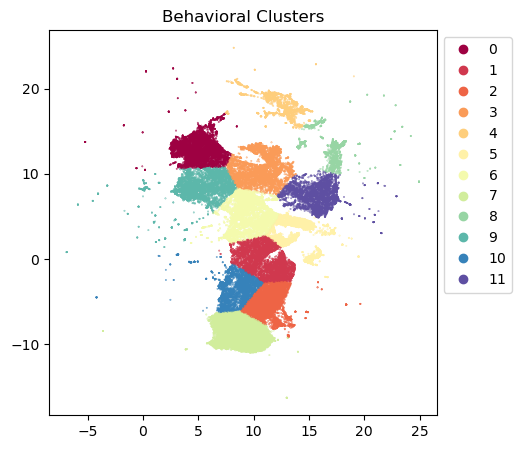

In [21]:
plt.figure(figsize=(5,5))
scatter = plt.scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['enhanced_kmeans_labels'],
            label=subsample_cluster_df['enhanced_kmeans_labels'],
            s=0.1,
            cmap='Spectral')
plt.title('Behavioral Clusters')
plt.legend(*scatter.legend_elements(), bbox_to_anchor = (1,1))
plt.show()

### Feature overlay plots

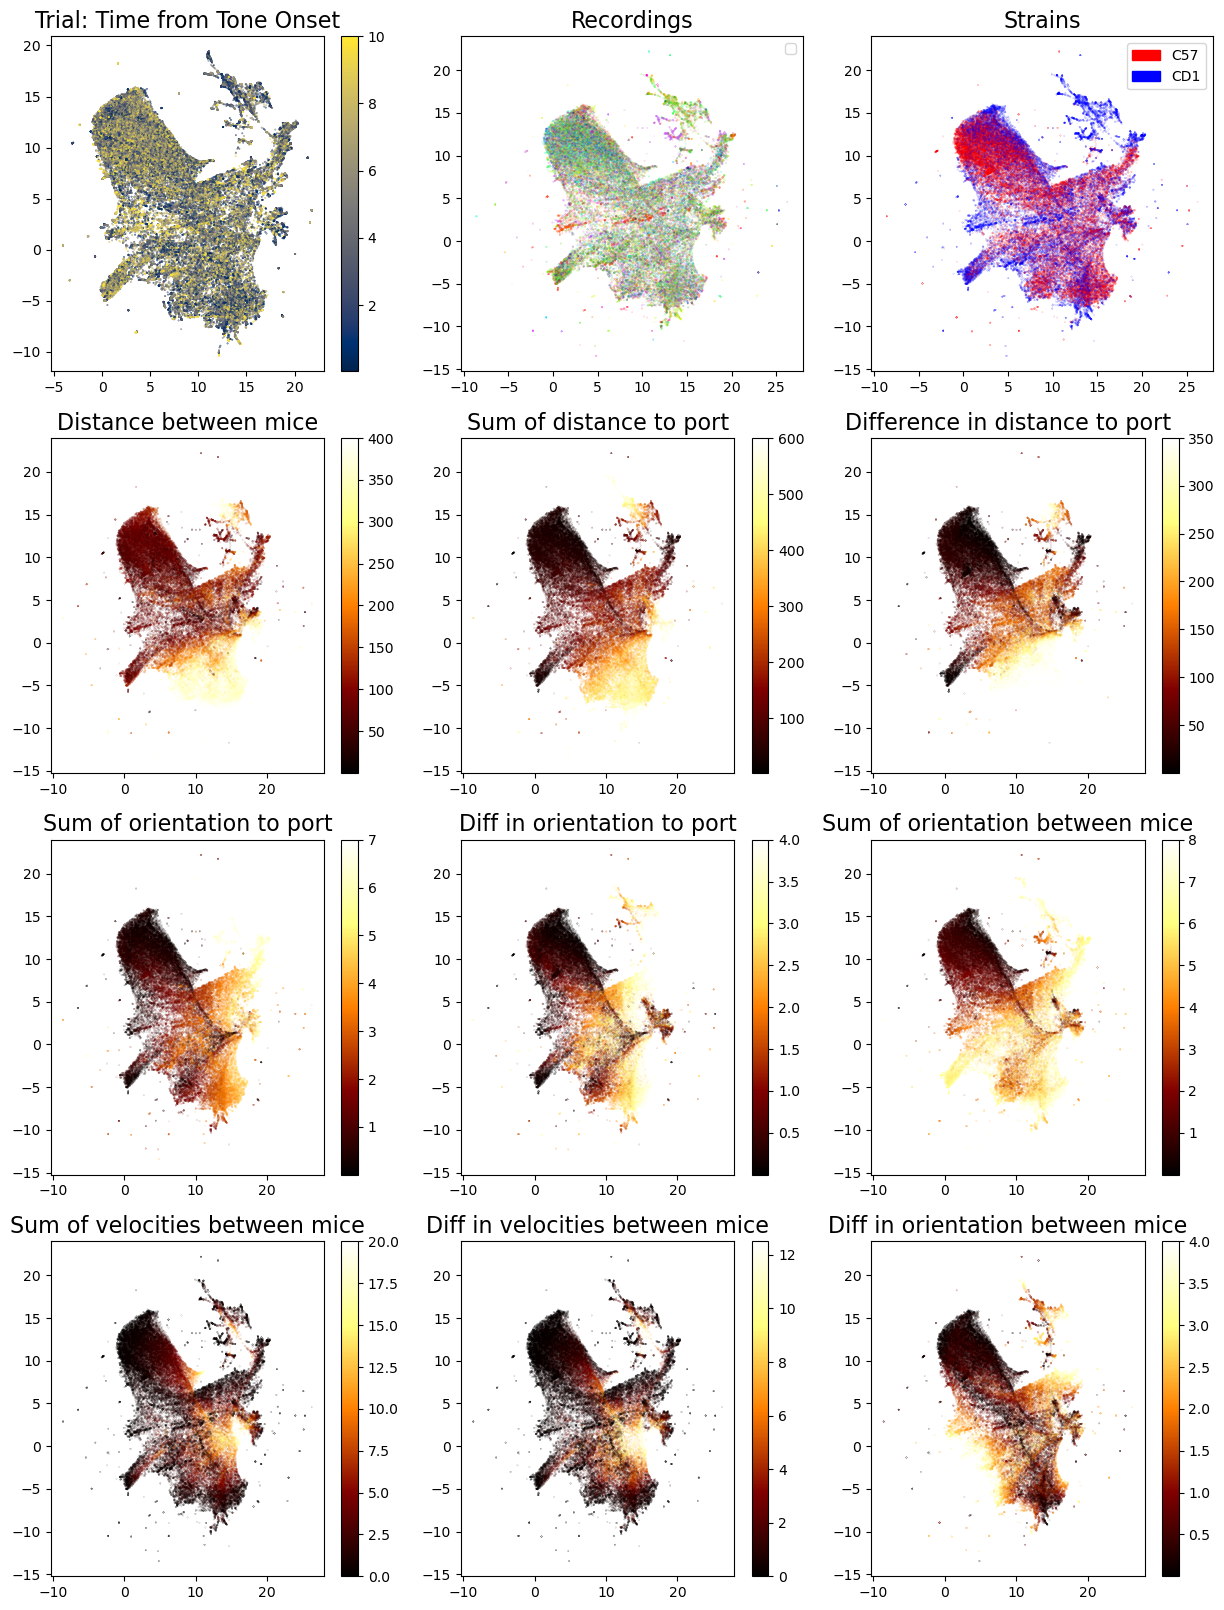

In [22]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(4, 3, figsize=(15, 20))
scatter1 = ax[0,0].scatter(trial_df['embedding_x_standard'],
            trial_df['embedding_y_standard'],
            c=trial_df['trial_indice'].astype(float),
            s=0.1,
            cmap='cividis')
ax[0,0].set_title('Trial: Time from Tone Onset', fontsize= 16)

scatter2 = ax[0,1].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['Recording'].map(recording_colors),
            label = subsample_cluster_df['Recording'],
            s=0.005)   
ax[0,1].set_title('Recordings', fontsize= 16)
legend2 = ax[0,1].legend(*scatter2.legend_elements(), bbox_to_anchor = (1,1))

scatter3 = ax[0,2].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['Strain'].map(strain_colors),
            label=subsample_cluster_df['Strain'],
            s=0.005)  
ax[0,2].set_title('Strains', fontsize= 16)
legend_handles3 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
legend3 = ax[0,2].legend(handles = legend_handles3, bbox_to_anchor = (1,1))

scatter4 = ax[1,0].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['thorax distances'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 400)  
ax[1,0].set_title('Distance between mice', fontsize= 16)

scatter5 = ax[1,1].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['distance to port sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 600)  
ax[1,1].set_title('Sum of distance to port', fontsize= 16)

scatter6 = ax[1,2].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['distance to port diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 350)  
ax[1,2].set_title('Difference in distance to port', fontsize= 16)

scatter7 = ax[2,0].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['orientation to port sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax=7)  
ax[2,0].set_title('Sum of orientation to port', fontsize= 16)

scatter8 = ax[2,1].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['orientation to port diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 4)  
ax[2,1].set_title('Diff in orientation to port', fontsize= 16)

scatter9 = ax[2,2].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['orientation b/w mice sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 8)  
ax[2,2].set_title('Sum of orientation between mice', fontsize= 16)


scatter10 = ax[3,2].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['orientation b/w mice diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 4)  
ax[3,2].set_title('Diff in orientation between mice', fontsize= 16)

scatter11 = ax[3,0].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['mouse velocity sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 20)  
ax[3,0].set_title('Sum of velocities between mice', fontsize= 16)

scatter12 = ax[3,1].scatter(subsample_cluster_df['embedding_x_standard'],
            subsample_cluster_df['embedding_y_standard'],
            c=subsample_cluster_df['mouse velocity diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 12.5)  
ax[3,1].set_title('Diff in velocities between mice', fontsize= 16)


plt.colorbar(scatter1, ax=ax[0,0]) 
plt.colorbar(scatter4, ax=ax[1,0]) 
plt.colorbar(scatter5, ax=ax[1,1]) 
plt.colorbar(scatter6, ax=ax[1,2]) 
plt.colorbar(scatter7, ax=ax[2,0]) 
plt.colorbar(scatter8, ax=ax[2,1]) 
plt.colorbar(scatter9, ax=ax[2,2]) 
plt.colorbar(scatter10, ax=ax[3,2]) 
plt.colorbar(scatter11, ax=ax[3,0]) 
plt.colorbar(scatter12, ax=ax[3,1]) 

#legend_handles4 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
#legend3 = ax[3].legend(handles = legend_handles3)
plt.savefig('./feature_clusters.png')
plt.show()


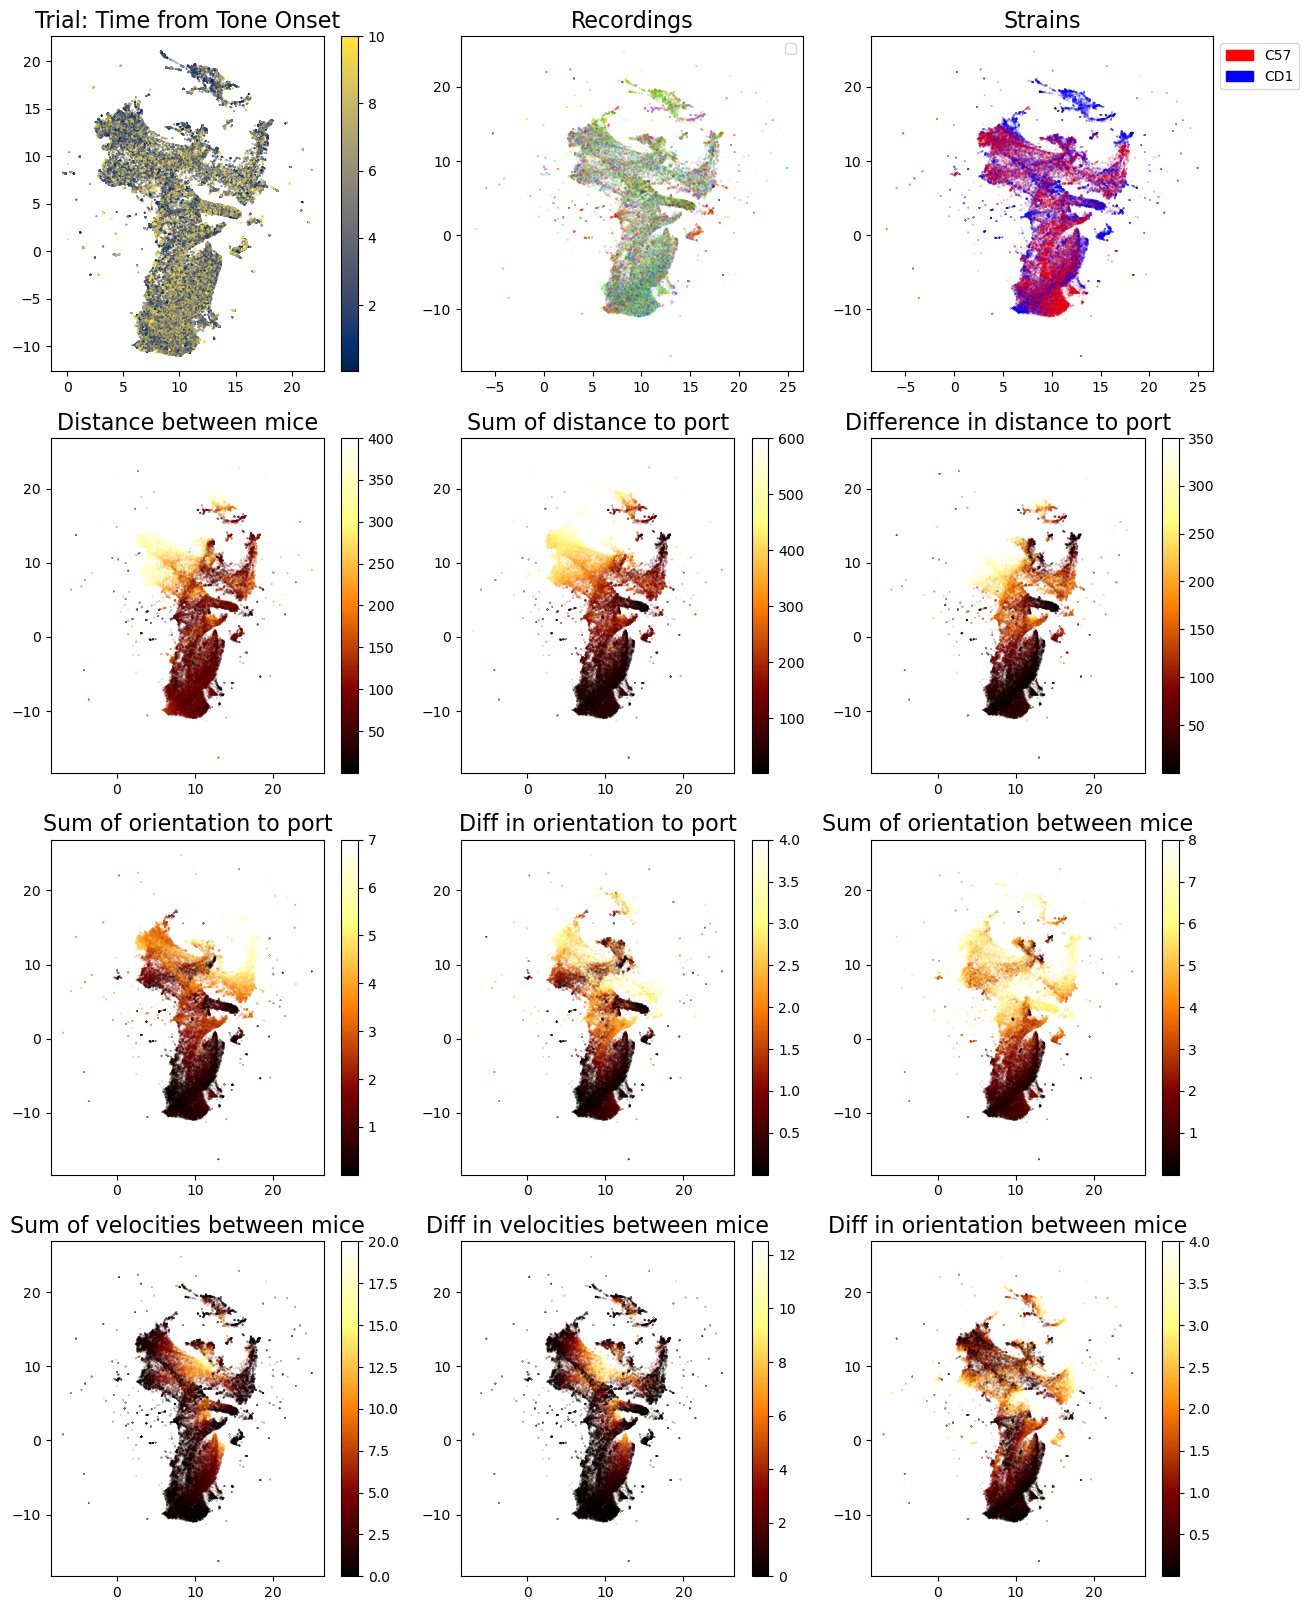

In [23]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(4, 3, figsize=(15, 20))
scatter1 = ax[0,0].scatter(trial_df['embedding_x'],
            trial_df['embedding_y'],
            c=trial_df['trial_indice'].astype(float),
            s=0.1,
            cmap='cividis')
ax[0,0].set_title('Trial: Time from Tone Onset', fontsize= 16)

scatter2 = ax[0,1].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['Recording'].map(recording_colors),
            label = subsample_cluster_df['Recording'],
            s=0.005)   
ax[0,1].set_title('Recordings', fontsize= 16)
legend2 = ax[0,1].legend(*scatter2.legend_elements(), bbox_to_anchor = (1,1))

scatter3 = ax[0,2].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['Strain'].map(strain_colors),
            label=subsample_cluster_df['Strain'],
            s=0.005)  
ax[0,2].set_title('Strains', fontsize= 16)
legend_handles3 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
legend3 = ax[0,2].legend(handles = legend_handles3, bbox_to_anchor = (1,1))

scatter4 = ax[1,0].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['thorax distances'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 400)  
ax[1,0].set_title('Distance between mice', fontsize= 16)

scatter5 = ax[1,1].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['distance to port sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 600)  
ax[1,1].set_title('Sum of distance to port', fontsize= 16)

scatter6 = ax[1,2].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['distance to port diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 350)  
ax[1,2].set_title('Difference in distance to port', fontsize= 16)

scatter7 = ax[2,0].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['orientation to port sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax=7)  
ax[2,0].set_title('Sum of orientation to port', fontsize= 16)

scatter8 = ax[2,1].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['orientation to port diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 4)  
ax[2,1].set_title('Diff in orientation to port', fontsize= 16)

scatter9 = ax[2,2].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['orientation b/w mice sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 8)  
ax[2,2].set_title('Sum of orientation between mice', fontsize= 16)


scatter10 = ax[3,2].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['orientation b/w mice diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 4)  
ax[3,2].set_title('Diff in orientation between mice', fontsize= 16)

scatter11 = ax[3,0].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['mouse velocity sum'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 20)  
ax[3,0].set_title('Sum of velocities between mice', fontsize= 16)

scatter12 = ax[3,1].scatter(subsample_cluster_df['embedding_x'],
            subsample_cluster_df['embedding_y'],
            c=subsample_cluster_df['mouse velocity diff'].astype(float),
            s=0.005, cmap = 'afmhot', vmax = 12.5)  
ax[3,1].set_title('Diff in velocities between mice', fontsize= 16)


plt.colorbar(scatter1, ax=ax[0,0]) 
plt.colorbar(scatter4, ax=ax[1,0]) 
plt.colorbar(scatter5, ax=ax[1,1]) 
plt.colorbar(scatter6, ax=ax[1,2]) 
plt.colorbar(scatter7, ax=ax[2,0]) 
plt.colorbar(scatter8, ax=ax[2,1]) 
plt.colorbar(scatter9, ax=ax[2,2]) 
plt.colorbar(scatter10, ax=ax[3,2]) 
plt.colorbar(scatter11, ax=ax[3,0]) 
plt.colorbar(scatter12, ax=ax[3,1]) 

#legend_handles4 = [Patch(color=color, label=label) for label, color in strain_colors.items()]
#legend3 = ax[3].legend(handles = legend_handles3)
plt.savefig('./feature_clusters.png')
plt.show()


## Cluster Analysis

### Strain

Text(0, 0.5, 'Number of Frames')

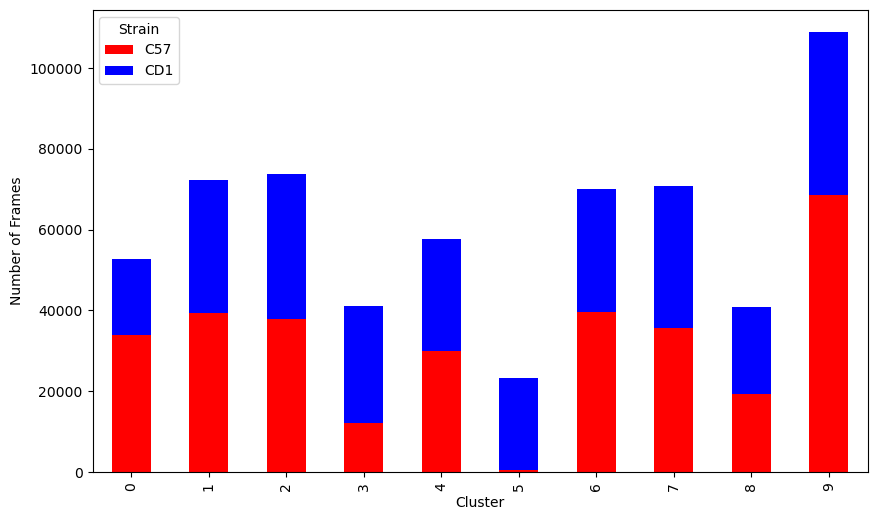

In [6]:
cluster_grouping = clustered_df.groupby(['kmeans_label','Strain'])
strain_counts = cluster_grouping['Strain'].value_counts().unstack()
strain_counts.plot(kind='bar', stacked=True, color = ['r','b'],figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Number of Frames')







### Trial


<Figure size 640x480 with 0 Axes>

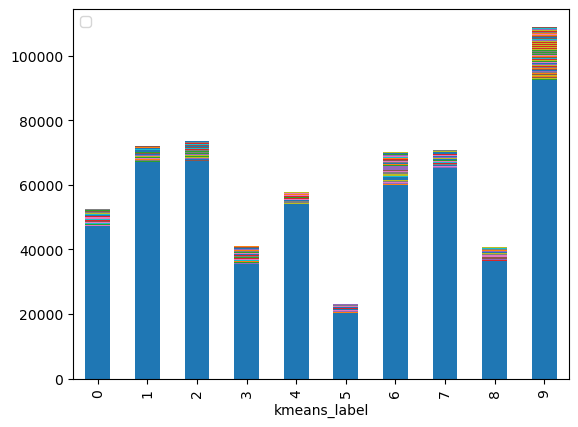

In [25]:
cluster_grouping_trial = subsample_df.groupby(['kmeans_label','trial_indice'])

trial_counts = cluster_grouping_trial['trial_indice'].value_counts().unstack()
plt.figure()
trial_counts.plot(kind='bar', stacked=True)    
plt.legend([]) 

(20000.12, 114387.0)

<Figure size 640x480 with 0 Axes>

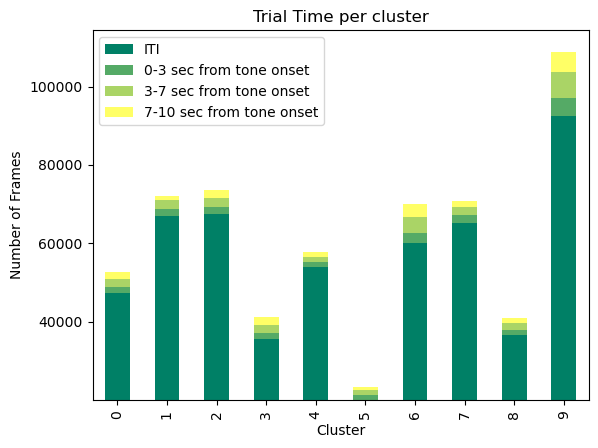

In [26]:
def categorize_trial_indices(value):
    value = float(value)
    if value == 0:
        return 'ITI'
    elif 0 < value <= 3:
        return '0-3 sec from tone onset'
    elif 3 < value <= 7:
        return '3-7 sec from tone onset'
    elif 7 < value <= 10:
        return '7-10 sec from tone onset'
    else:
        return None  
    

# Assign values based on the ranges
subsample_df['simplified_trial_indice'] = subsample_df['trial_indice'].apply(lambda x: categorize_trial_indices(x))
trial_colors = make_color_dict('simplified_trial_indice', subsample_df, 'summer')

cluster_grouping_trial = subsample_df.groupby(['kmeans_label','simplified_trial_indice'])

trial_counts = cluster_grouping_trial['simplified_trial_indice'].value_counts().unstack()
trial_counts = trial_counts[['ITI','0-3 sec from tone onset',
 '3-7 sec from tone onset',
 '7-10 sec from tone onset'
 ]]


plt.figure()
trial_counts.plot(kind='bar', stacked=True, color = trial_colors)    
plt.legend()
plt.xlabel('Cluster')
plt.ylabel('Number of Frames')
plt.title('Trial Time per cluster')
plt.ylim((20000.120000))

## GIF Creation

In [27]:
def cluster_gifs(all_cluster_df, cluster_label, gif_length,vid_folder, output_directory):
    no_clusters = len(all_cluster_df[cluster_label].unique())
    i = 1
    for cluster in all_cluster_df[cluster_label].unique():
        print(f'working on {i} out of {no_clusters} cluster gifs')
        cluster_df = all_cluster_df[all_cluster_df[cluster_label] == cluster]
        random_indices = np.random.choice(len(cluster_df), size=gif_length*30, replace=False)
        gif_df = cluster_df.iloc[random_indices]
        #gif_df.to_excel(os.path.join('tester.xlsx', output_directory))
        grouped = gif_df.groupby('Recording')['frame indice'].apply(list).reset_index()
        frames_df = grouped.apply(lambda row: extract_frames(row['Recording'], row['frame indice'], vid_folder), axis = 1)
        create_gif(cluster, frames_df, output_directory)
        i+=1

def find_vid(vid_name, folder):
    ending = ".mp4"
    for filename in os.listdir(folder):
        if filename.endswith(ending) and vid_name in filename:
            video_path = os.path.join(folder, filename)
    return video_path

def extract_frames(vid_name, frame_list, directory):
    # Open the video file
    video_path = find_vid(vid_name, directory)
    cap = cv2.VideoCapture(video_path)
    frames = []
    for frame_index in frame_list:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(float(frame_index))-1)
        success, frame = cap.read()
        if success:
            resized_frame = cv2.resize(frame, (640, 480))
            frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    return frames
        
def create_gif(cluster, df, output_directory):
    gif_frames = []
    for recording in range(len(df.index)):
        row = df.loc[recording]
        i = 0
        for frame in row:
            resized_frame = cv2.resize(frame, (640, 480))
            frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            gif_frames.append(frame_rgb)
            i +=1
    gif_path = os.path.join(output_directory, f"cluster{cluster}.gif")
    imageio.mimsave(gif_path, gif_frames, format='GIF', duration=3)

vid_folder = r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\data\videos'
output_directory = r'C:\Users\megha\Documents\GitHub\social_dominance_active_inference\results\cluster_gifs'
cluster_gifs(clustered_df, cluster_label = 'kmeans_label', gif_length = 5, vid_folder=vid_folder, output_directory=output_directory)

   

working on 1 out of 10 cluster gifs
working on 2 out of 10 cluster gifs
working on 3 out of 10 cluster gifs
working on 4 out of 10 cluster gifs
working on 5 out of 10 cluster gifs
working on 6 out of 10 cluster gifs
working on 7 out of 10 cluster gifs
working on 8 out of 10 cluster gifs
working on 9 out of 10 cluster gifs
working on 10 out of 10 cluster gifs


## Ethogram

In [39]:
# goal is to create a bar graph for one recording 
file = '10-03-22_Test_23_5-2v5-4'
tester_df = clustered_df[clustered_df['Recording'] == file]
tester_df[['frame indice', 'kmeans_label']]

,frame indice,kmeans_label
502329,2.0,5
502332,5.0,5
502335,8.0,5
502338,11.0,5
502341,14.0,5
...,...,...
557955,55628.0,4
557958,55631.0,4
557961,55634.0,4
557964,55637.0,4


In [100]:
def get_indices(df, cluster_label):
    """
    Takes in an indexed key or a list of repeated items, 
    creates a list of indices that correspond to each unique item. 
    
    Args (1):
        repeated_items_list: list, list of repeated items 
    
    Returns:
        item_indices: list of tuples, where the first element is the first index 
                      of an item, and the second element is the last index of that 
                      item 
    """
    is_first = True
    item_indices = {}
    durations = {}
    for i in range(len(df)):
        if is_first:
            current_item = df.iloc[i][cluster_label]
            start_index = df.iloc[i]['frame indice']
            current_recording = df.iloc[i]['Recording']
            start_index = float(start_index)/30/60
            is_first = False
        if df.iloc[i]['Recording'] != current_recording:
            end_index = df.iloc[i-1]['frame indice']
            end_index = float(end_index)/30/60
            indice_list = item_indices[current_item]
            indice_list.append([start_index,end_index])
            durations[current_item].append(end_index - start_index)
            item_indices[current_item] = indice_list
            current_recording = df.iloc[i]['Recording']
            start_index = df.iloc[i]['frame indice']
            start_index = float(start_index)/30/60
        if i == (len(df)-1):
            end_index = df.iloc[i]['frame indice']
            end_index = float(end_index)/30/60
            indice_list = item_indices[current_item]
            indice_list.append([start_index,end_index])
            durations[current_item].append(end_index - start_index)
            item_indices[current_item] = indice_list
        if (not is_first) & (df.iloc[i]['Recording'] == current_recording):
            if df.iloc[i][cluster_label] != current_item:
                end_index = df.iloc[i]['frame indice']
                end_index = float(end_index)/30/60
                if current_item in item_indices.keys():
                    indice_list = item_indices[current_item]
                    indice_list.append([start_index,end_index])
                    durations[current_item].append(end_index - start_index)
                    if (end_index - start_index) < 0:
                        print('cluster', current_item)
                        print('frame',df.iloc[i-1]['frame indice'] )
                        print(current_recording)
                        print(end_index)
                        print(start_index)
                    item_indices[current_item] = indice_list
                else: 
                    item_indices[current_item] = [[start_index, end_index]]
                    durations[current_item] = [end_index - start_index]
                start_index = df.iloc[i]['frame indice']
                start_index = float(start_index)/30/60
                current_item = df.iloc[i][cluster_label] 
    return item_indices, durations

cluster_dict, durations = get_indices(clustered_df, 'kmeans_label')



  

In [101]:
cluster_colors = make_color_dict('kmeans_label', tester_df, cmap='Spectral')

In [140]:
avg_durations = {}
for cluster, duration in durations.items():
    duration_min = np.array(duration)*60
    avg_duration = np.mean(duration_min)
    med_durations = np.median(duration_min)
    max_beh = np.max(duration_min)
    min_beh = np.min(duration_min)
    no_events = len(duration)
    avg_durations[cluster] = [avg_duration, med_durations, max_beh]#, min_beh]#, no_events]
    

cluster_info = pd.DataFrame.from_dict(avg_durations, orient = 'index')
cluster_info.columns = ['Average Duration (s)','Median (s)', 'Max (s)'] #'Min(s)']#, 'Number of events']
cluster_info

,Average Duration (s),Median (s),Max (s)
1,1.408039,0.7,18.3
4,0.567882,0.3,22.4
8,0.702360,0.3,35.4
7,0.742159,0.3,27.1
5,1.566870,0.3,45.7
2,0.494847,0.2,28.7
6,0.319335,0.2,6.0
0,0.476660,0.2,20.0
9,0.677469,0.3,23.4
3,0.562322,0.3,23.0


In [175]:
fills = ['/','+','',]*10
fills

['/',
 '+',
 '',
 '/',
 '+',
 '',
 '/',
 '+',
 '',
 '/',
 '+',
 '',
 '/',
 '+',
 '',
 '/',
 '+',
 '',
 '/',
 '+',
 '',
 '/',
 '+',
 '',
 '/',
 '+',
 '',
 '/',
 '+',
 '']

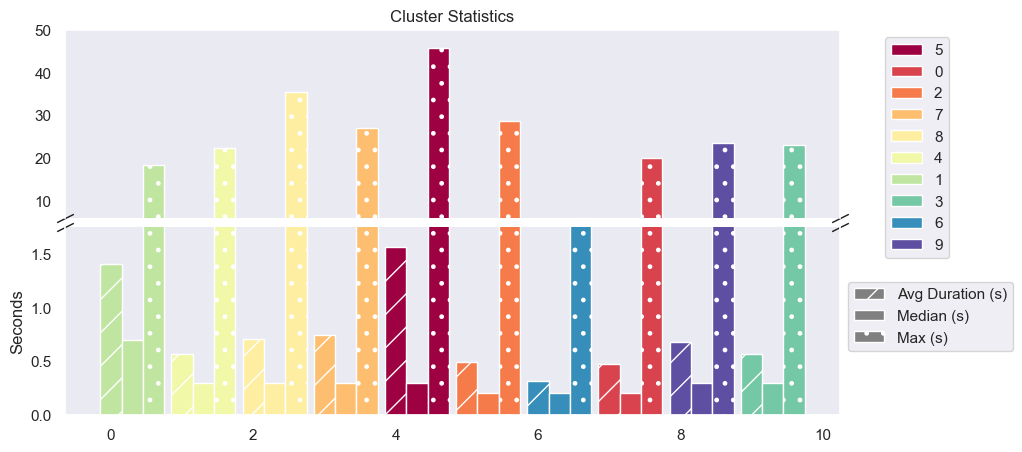

In [199]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,5), sharex=True, facecolor='white')
fig.subplots_adjust(hspace=0.05) 
import matplotlib.patches as mpatches

colors = list(cluster_colors.values())
fills = ['/','','.']*10
# Loop through each cluster (index) and plot the bars
for i, cluster in enumerate(cluster_info.index):
    cluster_data = cluster_info.loc[cluster]
    bar_width = 0.3
    x_positions = [i + bar_width * j for j in range(len(cluster_data))]
    for j, (x, value) in enumerate(zip(x_positions, cluster_data)):
        hatch_pattern = fills[j % len(fills)]  # Use modulo to cycle through fill patterns
        # Plot on the first subplot (0-1 on y-axis)
        ax1.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern)
        # Plot on the second subplot (0-1 on y-axis)
        ax2.bar(x, value, width=bar_width, color=cluster_colors[cluster], hatch=hatch_pattern)
    #ax1.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
    #ax2.bar(x_positions, cluster_data, width=bar_width, label=f'Cluster {cluster}', color=colors[i], hatch = fills)
# ax2.set_xticks([j + 1.5 * bar_width * i for i in range(len(cluster_info.columns)) for j in range(len(cluster_info))])
# ax2.set_xticklabels([col for col in cluster_info.columns for _ in range(len(cluster_info))], rotation=45, ha='right')
ax1.set_ylim(6, 50)  # outliers only
ax2.set_ylim(0, 1.75)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labelbottom=False)   # don't put tick labels at the top

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# Set labels and title


ax2.set_ylabel('Seconds')
ax1.set_title('Cluster Statistics')

# Add legend

cluster_labels = []
for cluster, color in cluster_colors.items():
    cluster_labels.append(mpatches.Patch(facecolor=color,  label=cluster))
                          
ax1.legend(handles = cluster_labels, bbox_to_anchor=(1.15,1))                   
patch_max = mpatches.Patch(facecolor='gray', hatch='.', label='Max (s)')
patch_avg = mpatches.Patch(facecolor='gray', hatch='/', label='Avg Duration (s)')
patch_median = mpatches.Patch(facecolor='gray', hatch='', label='Median (s)')

# Plotting empty bars to display the legend


# Create the legend
ax2.legend(handles=[ patch_avg, patch_median, patch_max], bbox_to_anchor=(1,.75))
ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.show()



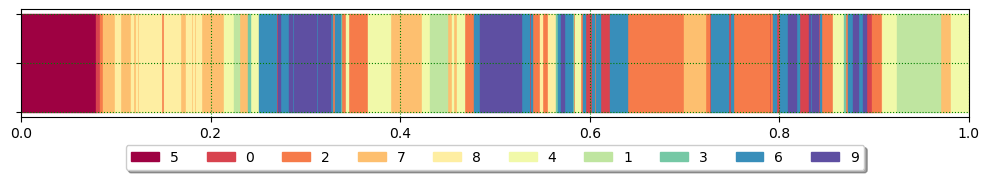

In [74]:
fig, axs = plt.subplots(figsize=(10, 2), nrows=1, ncols=1, sharex=True)   
y_labels = list(cluster_dict.keys())
max_len = len(y_labels)
obs_length = len(tester_df)
min_time = 0.0
max_time = float(obs_length)
bars = {}
par1 = 1
i = 0
bar_height = 1
for cluster_label in y_labels:
    start_stops = cluster_dict[cluster_label]
    starts = np.array([float(x[0]) for x in start_stops])
    stops = np.array([float(x[1]) for x in start_stops])
    bars[cluster_label] = [starts,stops]
# color
    bar_color = cluster_colors[cluster_label]
    axs.barh(
    1,
    stops - starts,
    left=starts,
    height=bar_height,
    align="center",
    edgecolor=bar_color,
    color=bar_color,
    alpha=1,
    label=cluster_label
    )
    i += 1

#axs.set_ylim(bottom=0, top=(max_len * par1) + par1)
pos = np.arange(par1, max_len * par1 + par1 + 1, par1)
#axs.set_yticks(pos[: len(y_labels)])
axs.set_yticklabels("")
axs.set_xlim((0,1))
#axs.set_ylabel("Cluster")
axs.grid(color="g", linestyle=":")
axs.set_xlabel("Minute")
axs.invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=10)
plt.tight_layout()
plt.show()

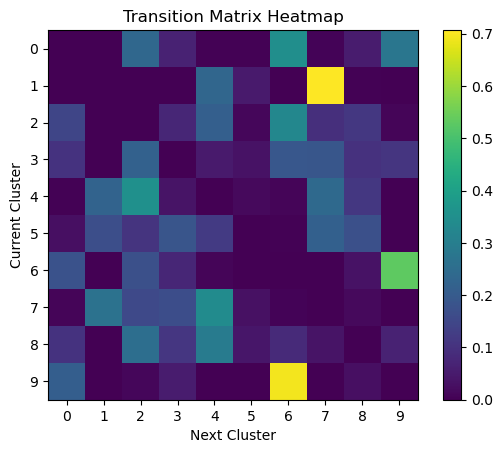

In [83]:
states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_states = len(states)
# Example sequence of transitions
transitions = np.array(clustered_df['kmeans_label'])
transitions = transitions[np.append([True], np.diff(transitions) != 0)]
# Create a transition matrix
transition_matrix = np.zeros((len(states), len(states)))

# Populate the transition matrix
for i in range(len(transitions) - 1):
    current_state = transitions[i]
    next_state = transitions[i + 1]
    transition_matrix[current_state][next_state] += 1

# Normalize to get probabilities
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Print the transition matrix
plt.imshow(transition_matrix, cmap='viridis', interpolation='nearest')

# Adding colorbar
plt.colorbar()

# Adding labels and title
plt.xlabel('Next Cluster')
plt.ylabel('Current Cluster')
plt.title('Transition Matrix Heatmap')
plt.xticks(np.arange(num_states), np.arange(num_states))

# Set y-axis ticks and labels
plt.yticks(np.arange(num_states), np.arange(num_states))
# Show the plot
plt.show()

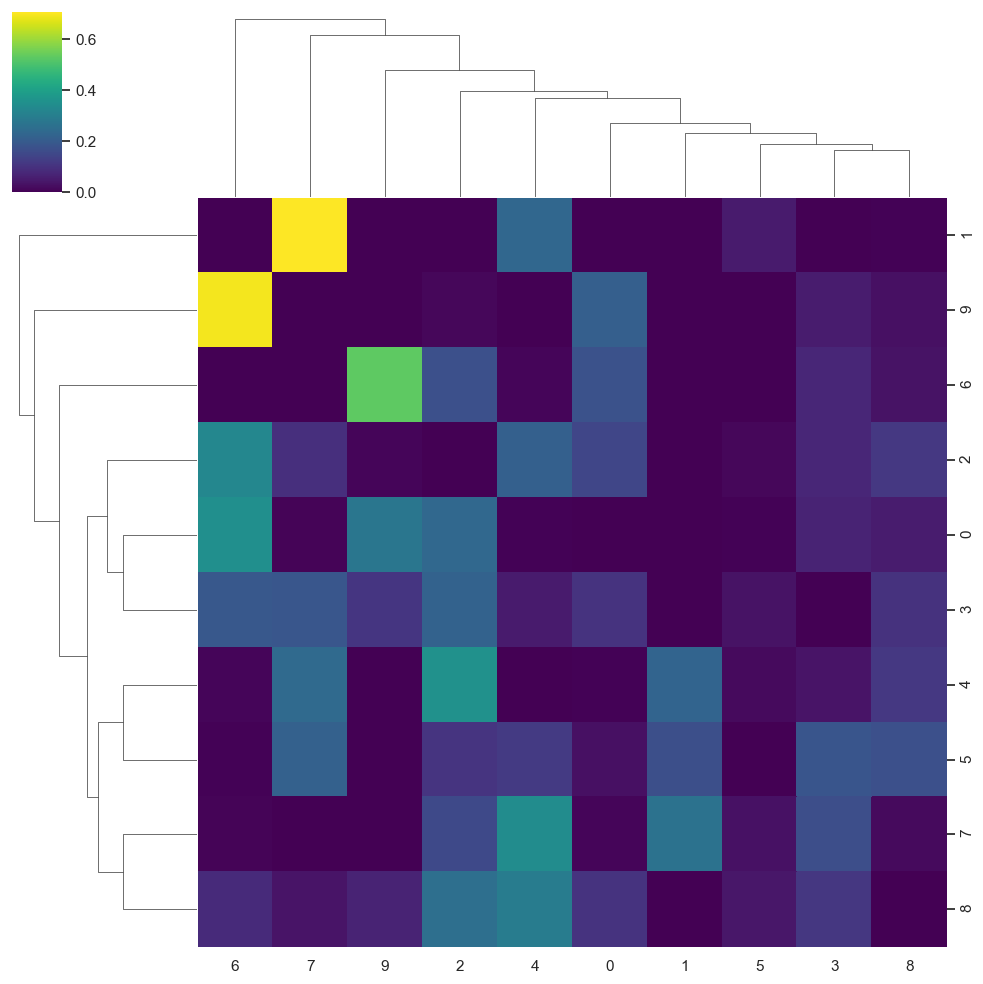

In [87]:
sns.set(font_scale=1)
sns.clustermap(transition_matrix, cmap='viridis')

# Show the plot
plt.show()